In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Tải dữ liệu MNIST
transform = transforms.ToTensor()  # Chuyển ảnh thành tensor
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.15MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.92MB/s]


XÂY DỰNG MÔ HÌNH CNN CƠ BẢN


In [15]:
# 2. Định nghĩa mô hình CNN
class MNIST_CNN(nn.Module):  # Tạo lớp MNIST_CNN kế thừa từ nn.Module (lớp cơ bản của PyTorch)
    def __init__(self):  # Hàm khởi tạo mô hình
        super(MNIST_CNN, self).__init__()  # Gọi hàm khởi tạo của lớp cha (nn.Module)
        # Tầng tích chập 1: 1 kênh đầu vào (ảnh đen trắng) -> 16 kênh đầu ra, filter 3x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)  # Tích chập giảm kích thước từ 28x28 -> 26x26
        # Tầng tích chập 2: 16 kênh đầu vào -> 32 kênh đầu ra, filter 3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)  # Tích chập giảm từ 12x12 -> 10x10 (sau pooling)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        # Tầng pooling: vùng 2x2, giảm kích thước một nửa
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Ví dụ: 26x26 -> 13x13, 10x10 -> 5x5
        # Tầng fully connected: từ 32 kênh * 5x5 (800) -> 10 lớp (0-9)
        self.fc1 = nn.Linear(64 * 1 * 1, 10)  # Duỗi feature map thành vector rồi phân loại

    def forward(self, x):  # Hàm forward định nghĩa luồng dữ liệu qua các tầng
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU (loại giá trị âm) -> Pool (giảm kích thước)
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool, cuối cùng ra 32x5x5
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 1 * 1)  # Duỗi tensor thành vector, -1 tự động tính batch size
        x = self.fc1(x)  # Qua tầng fully connected, ra 10 giá trị (logits cho 0-9)
        return x  # Trả về kết quả dự đoán

Khởi tạo mô hình


In [20]:
# Khởi tạo mô hình
model = MNIST_CNN()  # Tạo một instance của lớp MNIST_CNN
criterion = nn.CrossEntropyLoss()  # Định nghĩa hàm mất mát CrossEntropy (dùng cho phân loại nhiều lớp)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)  # Dùng SGD với learning rate 0.01 và momentum 0.9 để tối ưu

Huấn luyện mô hình

In [21]:
# 3. Huấn luyện mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Chọn GPU nếu có, không thì dùng CPU
model.to(device)  # Chuyển mô hình sang thiết bị đã chọn (GPU/CPU)

loss_values = []  # Tạo list để lưu giá trị mất mát trung bình của mỗi epoch
for epoch in range(10): # Lặp qua 5 epoch (mỗi epoch là một lần duyệt hết dữ liệu)
    running_loss = 0.0  # Biến để cộng dồn mất mát trong epoch
    for images, labels in train_loader:  # Lặp qua từng batch trong tập huấn luyện
        images, labels = images.to(device), labels.to(device)  # Chuyển ảnh và nhãn sang GPU/CPU

        optimizer.zero_grad()  # Xóa gradient cũ để tránh tích lũy từ bước trước
        outputs = model(images)  # Đưa ảnh qua mô hình, nhận dự đoán (logits)
        loss = criterion(outputs, labels)  # Tính mất mát giữa dự đoán và nhãn thật
        loss.backward()  # Tính gradient ngược (backpropagation)
        optimizer.step()  # Cập nhật trọng số dựa trên gradient

        running_loss += loss.item()  # Cộng dồn giá trị mất mát của batch
    epoch_loss = running_loss / len(train_loader)  # Tính mất mát trung bình của epoch
    loss_values.append(epoch_loss)  # Lưu mất mát trung bình vào list
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")  # In mất mát trung bình sau mỗi epoch

Epoch 1, Loss: 0.2752
Epoch 2, Loss: 0.1099
Epoch 3, Loss: 0.0928
Epoch 4, Loss: 0.0853
Epoch 5, Loss: 0.0774
Epoch 6, Loss: 0.0728
Epoch 7, Loss: 0.0694
Epoch 8, Loss: 0.0729
Epoch 9, Loss: 0.0731
Epoch 10, Loss: 0.0703


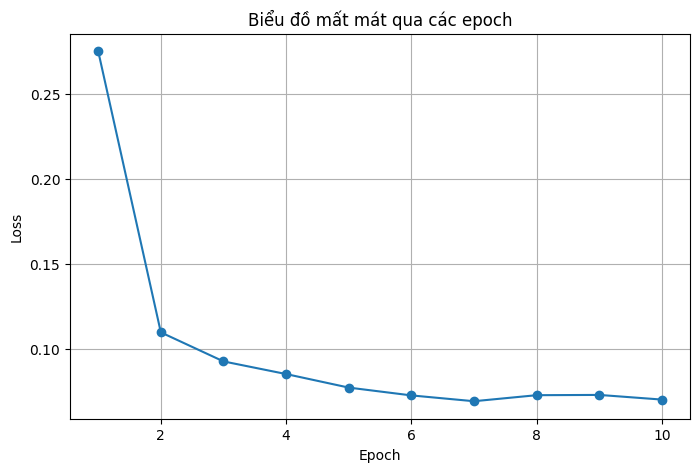

In [22]:
# Vẽ biểu đồ loss
plt.figure(figsize=(8, 5))  # Tạo khung hình kích thước 8x5
plt.plot(range(1, 11), loss_values, marker='o')  # Vẽ đường mất mát qua 5 epoch, thêm điểm đánh dấu
plt.title("Biểu đồ mất mát qua các epoch")  # Tiêu đề biểu đồ
plt.xlabel("Epoch")  # Nhãn trục x
plt.ylabel("Loss")  # Nhãn trục y
plt.grid(True)  # Thêm lưới để dễ nhìn
plt.show()  # Hiển thị biểu đồ

Đánh giá mô hình

In [19]:
correct = 0  # Đếm số dự đoán đúng
total = 0  # Đếm tổng số mẫu
with torch.no_grad():  # Tắt tính gradient vì chỉ đánh giá, không huấn luyện
    for images, labels in test_loader:  # Lặp qua từng batch trong tập kiểm tra
        images, labels = images.to(device), labels.to(device)  # Chuyển dữ liệu sang GPU/CPU
        outputs = model(images)  # Dự đoán trên batch ảnh
        _, predicted = torch.max(outputs.data, 1)  # Lấy chỉ số lớp có giá trị lớn nhất (dự đoán)
        total += labels.size(0)  # Cộng số mẫu trong batch vào tổng
        correct += (predicted == labels).sum().item()  # Cộng số dự đoán đúng
print(f"Độ chính xác trên tập test: {100 * correct / total:.2f}%")  # Tính và in độ chính xác (%)

Độ chính xác trên tập test: 98.24%


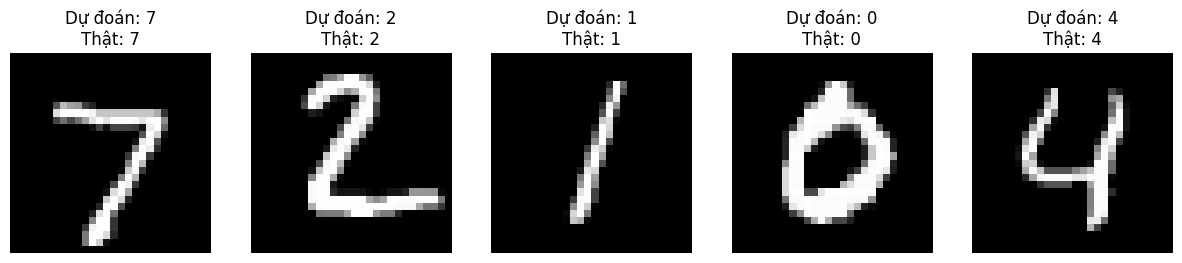

In [13]:
# Trực quan kết quả dự đoán
def visualize_prediction():  # Hàm để vẽ 5 ảnh và dự đoán
    model.eval()  # Chuyển mô hình sang chế độ đánh giá (tắt dropout, batch norm nếu có)
    images, labels = next(iter(test_loader))  # Lấy một batch từ tập kiểm tra
    images, labels = images.to(device), labels.to(device)  # Chuyển sang GPU/CPU
    outputs = model(images)  # Dự đoán trên batch
    _, predicted = torch.max(outputs, 1)  # Lấy chỉ số lớp dự đoán

    # Vẽ 5 ảnh đầu tiên
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Tạo lưới 1x5 để vẽ 5 ảnh
    for i in range(5):  # Lặp qua 5 ảnh đầu
        axes[i].imshow(images[i].cpu().squeeze(), cmap='gray')  # Vẽ ảnh (chuyển về CPU, bỏ kênh 1)
        axes[i].set_title(f"Dự đoán: {predicted[i].item()}\nThật: {labels[i].item()}")  # Ghi nhãn dự đoán và thật
        axes[i].axis('off')  # Tắt trục tọa độ
    plt.show()  # Hiển thị hình

visualize_prediction()  # Gọi hàm để vẽ


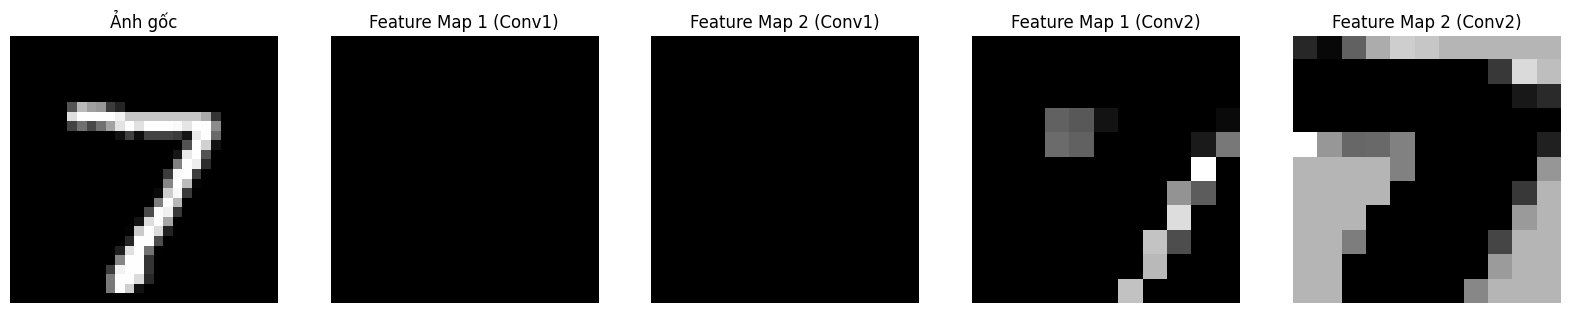

In [23]:
def visualize_feature_map():  # Hàm để vẽ ảnh gốc và feature map từ tầng conv1, conv2
    model.eval()  # Chuyển sang chế độ đánh giá
    images, _ = next(iter(test_loader))  # Lấy một batch từ tập kiểm tra (bỏ nhãn)
    img = images[0].unsqueeze(0).to(device)  # Lấy ảnh đầu tiên, thêm chiều batch (1x1x28x28)

    # Tính feature map từ conv1
    conv1_output = torch.relu(model.conv1(img))  # Qua conv1 và ReLU, ra tensor 1x16x26x26
    # Tính feature map từ conv2
    conv2_output = torch.relu(model.conv2(model.pool(torch.relu(model.conv1(img)))))  # Qua conv1, pool, conv2, ReLU

    # Vẽ ảnh gốc và feature map
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 5, 1)
    plt.title("Ảnh gốc")
    plt.imshow(img.cpu().squeeze(), cmap='gray')
    plt.axis('off')

    # Vẽ feature map đầu tiên từ conv1
    plt.subplot(1, 5, 2)
    plt.title("Feature Map 1 (Conv1)")
    plt.imshow(conv1_output[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    # Vẽ feature map thứ hai từ conv1
    plt.subplot(1, 5, 3)
    plt.title("Feature Map 2 (Conv1)")
    plt.imshow(conv1_output[0, 1].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    # Vẽ feature map đầu tiên từ conv2
    plt.subplot(1, 5, 4)
    plt.title("Feature Map 1 (Conv2)")
    plt.imshow(conv2_output[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')

    # Vẽ feature map thứ hai từ conv2
    plt.subplot(1, 5, 5)
    plt.title("Feature Map 2 (Conv2)")
    plt.imshow(conv2_output[0, 1].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

visualize_feature_map()

### Biểu đồ mất mát (loss) thay đổi khi epoch là 10 có xu hướng giảm đều
### Số epoch ảnh hưởng đến kết quả vì nó xác định số lần mô hình lặp qua toàn bộ tập dữ liệu huấn luyện để cập nhật trọng số. Nếu số epoch quá ít, mô hình không có đủ cơ hội học đầy đủ các đặc trưng của dữ liệu, dẫn đến hiện tượng underfitting (mất mát cao, độ chính xác thấp). Ngược lại, nếu số epoch quá nhiều, mô hình có thể học quá chi tiết trên dữ liệu huấn luyện, gây overfitting (hiệu quả tốt trên tập huấn luyện nhưng kém trên tập kiểm tra), làm giảm khả năng tổng quát hóa trên dữ liệu mới. Do đó, chọn số epoch phù hợp là yếu tố quan trọng để cân bằng giữa việc học đủ và tránh học quá mức.

## Câu 2: Thêm một tầng tích chập
### Thêm tầng tích chập giúp mô hình tìm kiếm và học các đặc trưng phức tạp hơn từ dữ liệu (như cạnh, góc, hoặc mẫu hình cao cấp), đặc biệt hiệu quả với dữ liệu không gian như ảnh. Điều này thường cải thiện độ chính xác bằng cách tăng khả năng biểu diễn, nhưng cũng có thể làm tăng nguy cơ overfitting nếu không điều chỉnh phù hợp.

#Câu 3: Thay đổi learning rate
### Epoch 1, Loss: 0.2752
###Epoch 2, Loss: 0.1099
###Epoch 3, Loss: 0.0928
###Epoch 4, Loss: 0.0853
###Epoch 5, Loss: 0.0774
###Epoch 6, Loss: 0.0728
###Epoch 7, Loss: 0.0694
###Epoch 8, Loss: 0.0729
###Epoch 9, Loss: 0.0731
###Epoch 10, Loss: 0.0703
### giảm chậm rồi tăng nhẹ ở Epoch 9 rồi tiếp tục giảm ở Epoch 10

#Câu 4: Vẽ thêm feature map từ tầng tích chập thứ hai
##Mô tả sự khác biệt giữa feature map từ conv1 và conv2
###Khi chạy code, feature map từ conv1 thường hiển thị các đặc trưng cơ bản như cạnh hoặc đường nét đơn giản của ảnh gốc (ví dụ: số trong MNIST), trong khi feature map từ conv2 trở nên trừu tượng hơn, kết hợp các đặc trưng phức tạp từ conv1 (như góc, mẫu hình) sau khi qua pooling và tích chập thêm. Kích thước của conv2_output nhỏ hơn (do pooling giảm độ phân giải), dẫn đến chi tiết bị cô đọng nhưng biểu diễn mức cao hơn.

##Sự khác biệt giữa feature map từ các tầng khác nhau (2-3 câu)
###Feature map từ tầng conv1 chủ yếu phát hiện các đặc trưng cấp thấp như cạnh và đường nét, trong khi conv2 tạo ra các đặc trưng cấp cao hơn, trừu tượng hơn như tổ hợp mẫu hình, do nó xử lý đầu ra của conv1 qua pooling và tích chập sâu hơn. Điều này làm cho feature map của conv2 nhỏ hơn về kích thước nhưng giàu thông tin ngữ nghĩa hơn.